# Stroke Prediction
Author: Kim Hazed Delfino

# Imports

In [2]:
import pandas as pd
import numpy as np
#libs for visuals
import matplotlib.pyplot as plt
import seaborn as sns
# Necessary libs 
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.compose import make_column_selector, make_column_transformer
# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import make_pipeline as resample_pipeline
# Metrics
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import warning filter to remove warning when adding new column to df
import warnings
warnings.filterwarnings("ignore")

c:\Users\kdelfino\anaconda3\envs\dojo-env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load the Data

In [3]:
path = r"C:\Users\kdelfino\Documents\GitHub\ML_stroke_prediction\healthcare-dataset-stroke-data.csv"
df = pd.read_csv(path)

## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [6]:
df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

 `Stroke Prediction`
- [Stroke_dataset]((https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/code))

- A Stroke is a health condition that causes damage by tearing the blood vessels in the brain. It can also occur when there is a halt in the blood flow and other nutrients to the brain. According to the World Health Organization (WHO), stroke is the leading cause of death and disability globally, This model will try to predict if a person will have stroke or not

- Each row represents a person's features

- This Model will solve a `Classification Problem`

- There area `11 Feature Matrices` in this dataset excluding `Target Vector`

- This dataset contains `5110 rows`

- I find this Dataset to be challenging because the ratio between target distribution is almost 9:1 in favor of 0's as opposed to 1's 

In [7]:
# Check for missing values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

- Looks like we have missing values in `bmi` feature, the amount of missing data is not high/low enough to justify dropping the column so we will have to handle them during pre-processing to avoid data leakage

In [8]:
# Drop id column for irrelevant data
df.drop(columns=['id','ever_married'],inplace=True)

- Dropped the `id` and `ever_married` columns since it's not providing any value to our prediction

In [9]:
#check for duplicate
df.duplicated().sum()

0

In [10]:
df.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3320,Male,60.0,0,0,Self-employed,Urban,69.53,26.2,never smoked,0
2179,Male,78.0,0,0,Private,Rural,80.09,21.8,never smoked,0
1319,Male,73.0,0,1,Self-employed,Rural,189.45,32.2,never smoked,0
2987,Female,15.0,0,0,Private,Urban,76.77,21.7,Unknown,0
819,Male,53.0,0,0,Private,Urban,126.35,25.2,never smoked,0


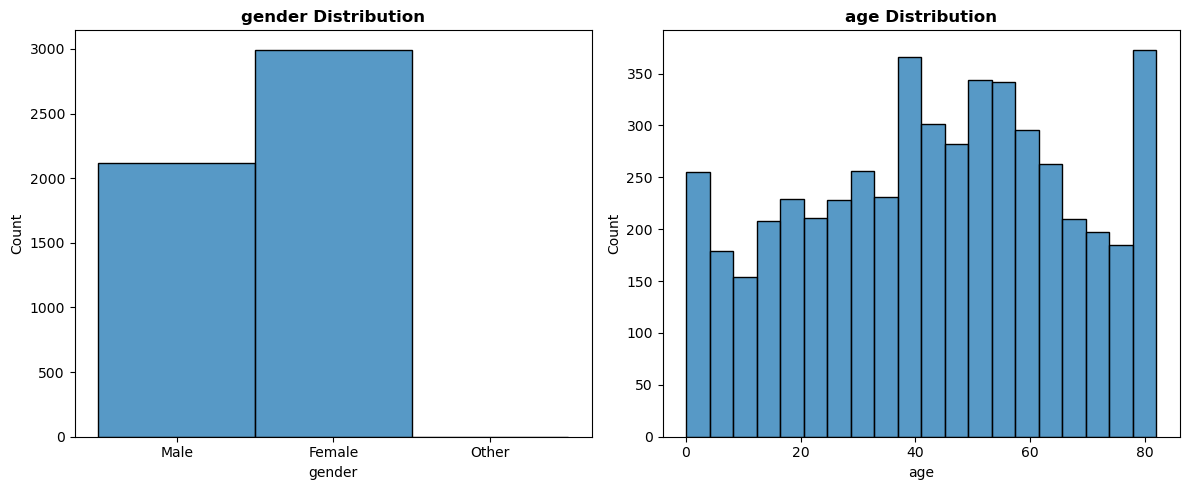

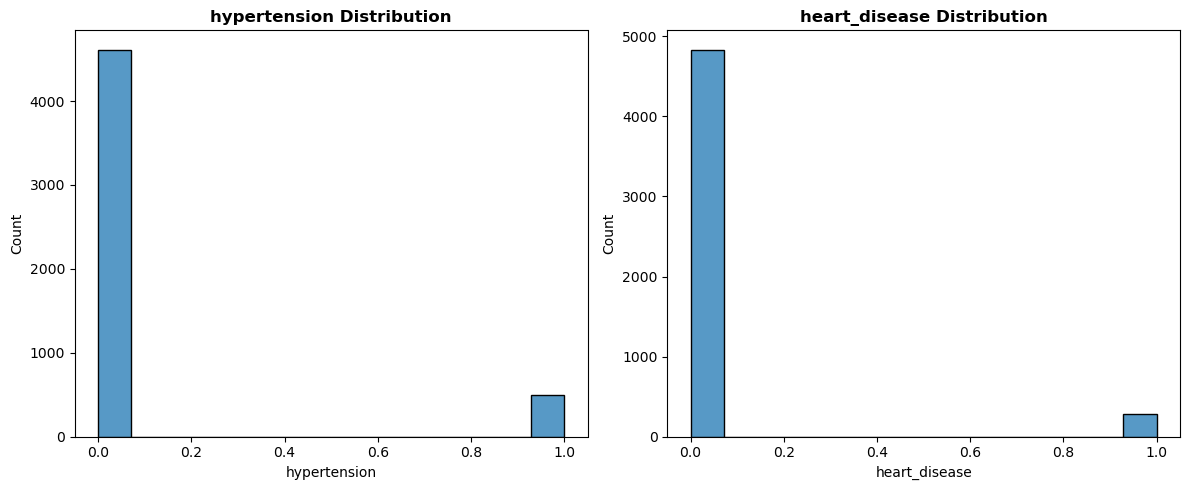

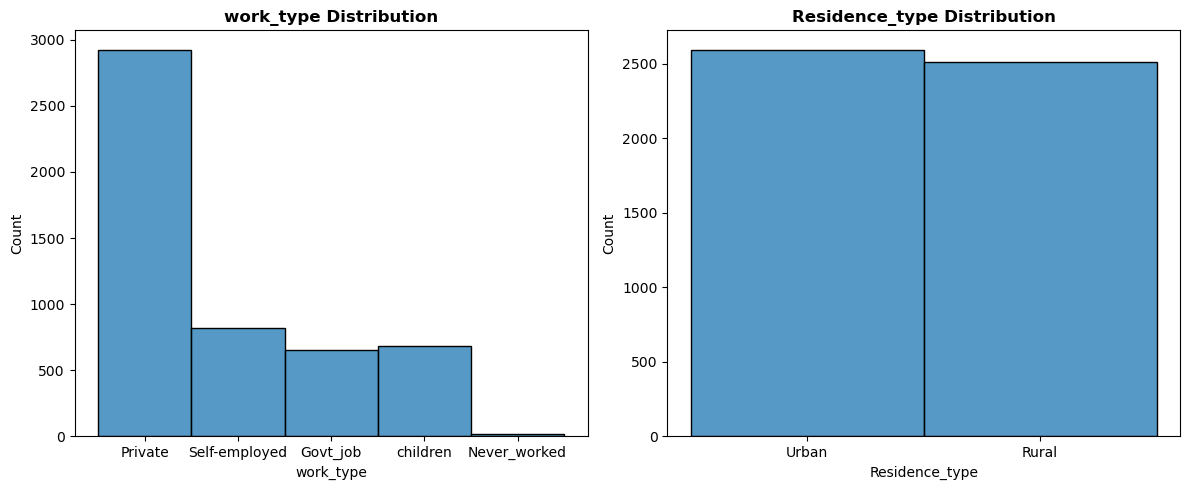

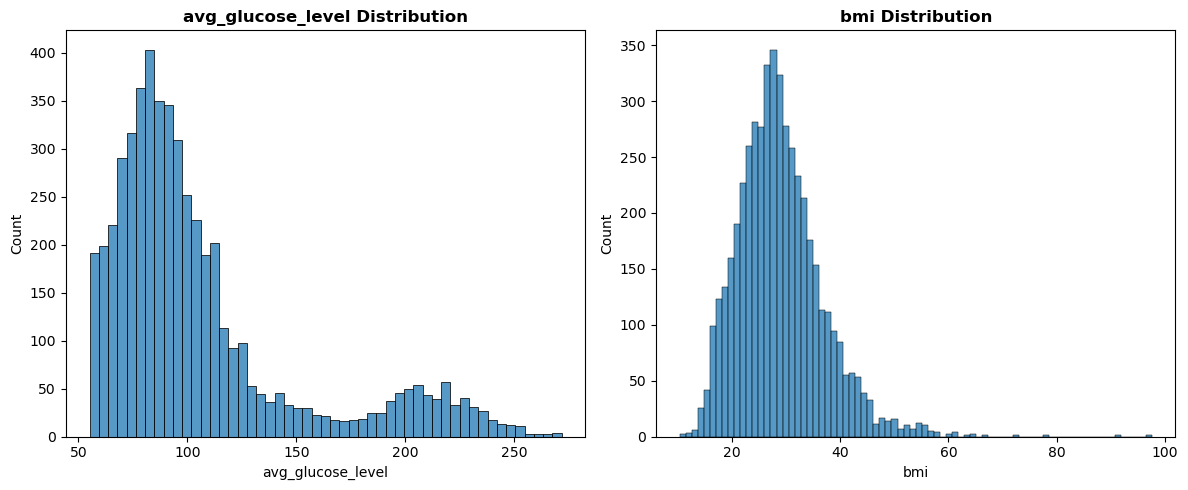

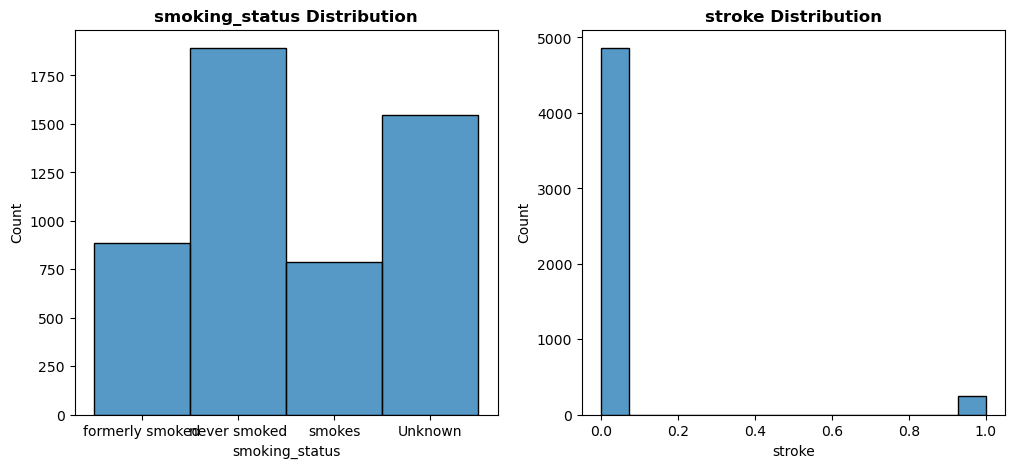

In [11]:
col_ax = 0
row_limit = 4
counter = 0
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
# Iterate to all features and display Historgram
for col in df.columns:
    # Set Historgram 
    ax=sns.histplot(data=df, x=col, ax=axes[col_ax])
    axes[col_ax].set_title(col+" Distribution", fontweight="bold")
    
    # Display every 2 cols and set new fig
    if col_ax == 1 and counter != row_limit:
        fig.tight_layout()
        fig, axes = plt.subplots(ncols=2, figsize=(12,5))
        col_ax = 0
        counter += 1
    else:
        col_ax += 1


- Here we can see the Distributions for all features and target
- `bmi` seemed to have impossible value but upon further research, there was a record in the past of bmi went as high as `105`
- `gender` have another data point called `other` that we need to look into
- `smoking_status` have a lot of `unknown` that we need to handle during preprocessing

### Check for Data Inconcistency

In [12]:
# Select all object colums
cat_cols = df.select_dtypes(include="object")

In [13]:
# Check for Naming Inconsistency
for col in cat_cols:
    print(f"Checking {col}:\n{df[col].value_counts()}")
    # Separtor for readability 
    print("___________________________")

Checking gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
___________________________
Checking work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
___________________________
Checking Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
___________________________
Checking smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
___________________________


In [14]:
chiledren_df = df[df["work_type"]== "children"]
chiledren_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,687.000000,687.0,687.000000,687.000000,671.000000,687.000000
mean,6.841339,0.0,0.001456,94.400277,20.038003,0.002911
std,4.533364,0.0,0.038152,26.658955,4.540639,0.053916
min,0.080000,0.0,0.000000,55.340000,10.300000,0.000000
25%,2.000000,0.0,0.000000,76.255000,17.150000,0.000000
50%,6.000000,0.0,0.000000,90.220000,18.900000,0.000000
75%,11.000000,0.0,0.000000,108.710000,21.600000,0.000000
max,16.000000,0.0,1.000000,219.810000,41.700000,1.000000


In [15]:
# Create filter for other
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,Private,Rural,143.33,22.4,formerly smoked,0


- `dropping` the gender `other` since it's insignificant value and outlier in our dataset

In [16]:
# Drop index where other is located
df.drop(index=3116,inplace=True)

In [17]:
# Double check
df[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [18]:
# Display dataset again
df.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4847,Female,30.0,0,0,Private,Urban,84.92,47.8,never smoked,0
3024,Female,57.0,0,0,Govt_job,Rural,87.10,48.3,smokes,0
3237,Female,36.0,0,0,Private,Urban,91.34,29.9,never smoked,0
4980,Female,19.0,0,0,Private,Urban,100.60,20.5,never smoked,0
4707,Female,61.0,0,0,Private,Rural,106.65,35.9,formerly smoked,0


### Multi Variate Exploratory Analysis

In [19]:
# Import warning to prevent warning messages
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Set Correlation from the entire numerical datapoints
corr = df.corr()
mask = np.triu(np.ones_like(corr))

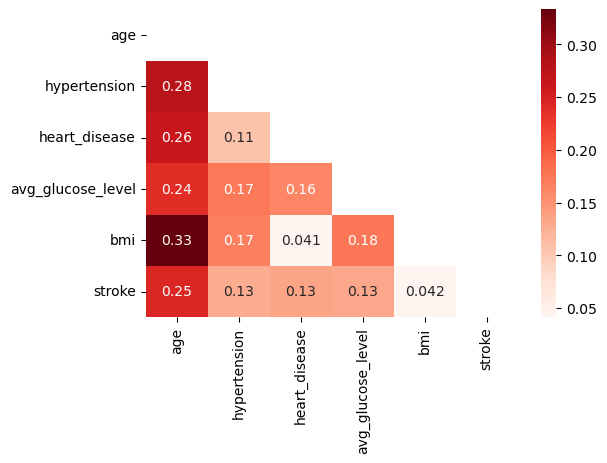

In [21]:
# Set Heatmap
fix, ax = plt.subplots(figsize= (6,4))
ax = sns.heatmap(corr, cmap='Reds', annot = True, mask= mask );

- Here we can see that we **`Do not`** have **`Moderate or Strong`** correlation between features but `Age` does show some correlation with the rest of numerical features with `bmi` being the highest

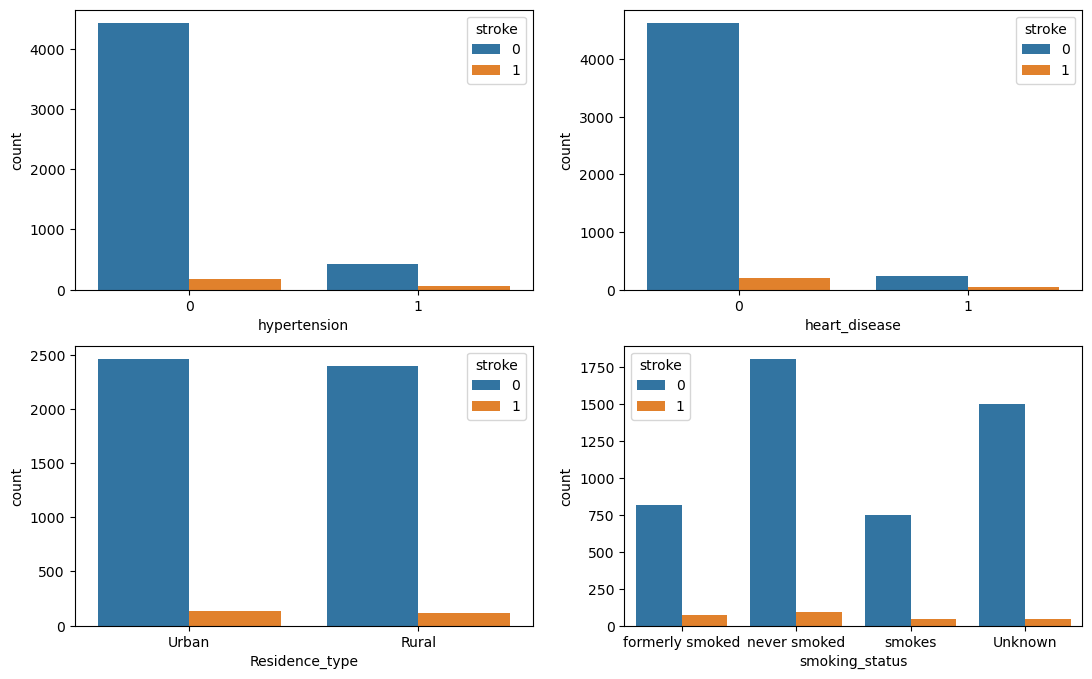

In [22]:
# Set fig to display calification features relative to stroke occurrence 
fig, axes = plt.subplots(nrows= 2,ncols=2,figsize=(13,8))
sns.countplot(data=df, x="hypertension",hue="stroke",ax=axes[0,0])
sns.countplot(data=df, x="heart_disease",hue="stroke",ax=axes[0,1])
sns.countplot(data=df, x="Residence_type",hue="stroke",ax=axes[1,0])
sns.countplot(data=df, x="smoking_status",hue="stroke",ax=axes[1,1]);


- Although historically medical experts have determined that having `hypertension` and `heart disease` could increase a person's risk of having a stroke, these graphs seemed to disagree. 
- `Residence type` doens't seem to have much influence to a person risk of having stroke since both location are relatively similar.
- Surprisingly, people who `smokes` shows the least amount of stroke occurrence. 

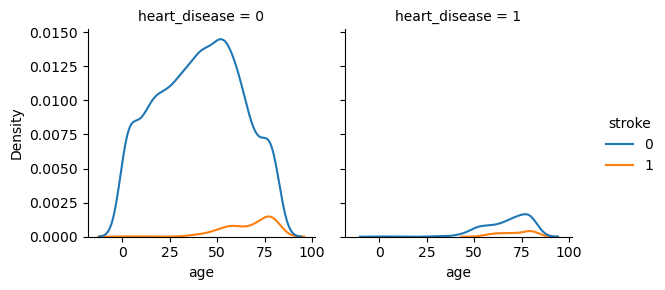

In [23]:
# Display plot age vs stroke occurrence relative to heart disease
sns.displot(
    df,
    x="age", hue="stroke",
    col="heart_disease", col_wrap=2, height=3,
    kind="kde",
);

- Here we're starting to see a trend, it seems that as the person gets older the higher the risk of having a stroke

In [24]:
# Create age filter starting at the first stroke was recorded
stroke_filtered = df[df["stroke"] == 1]

# Replace numeric binary to word binary for readability 
stroke_filtered.replace({0:"False",1:"True"},inplace=True)


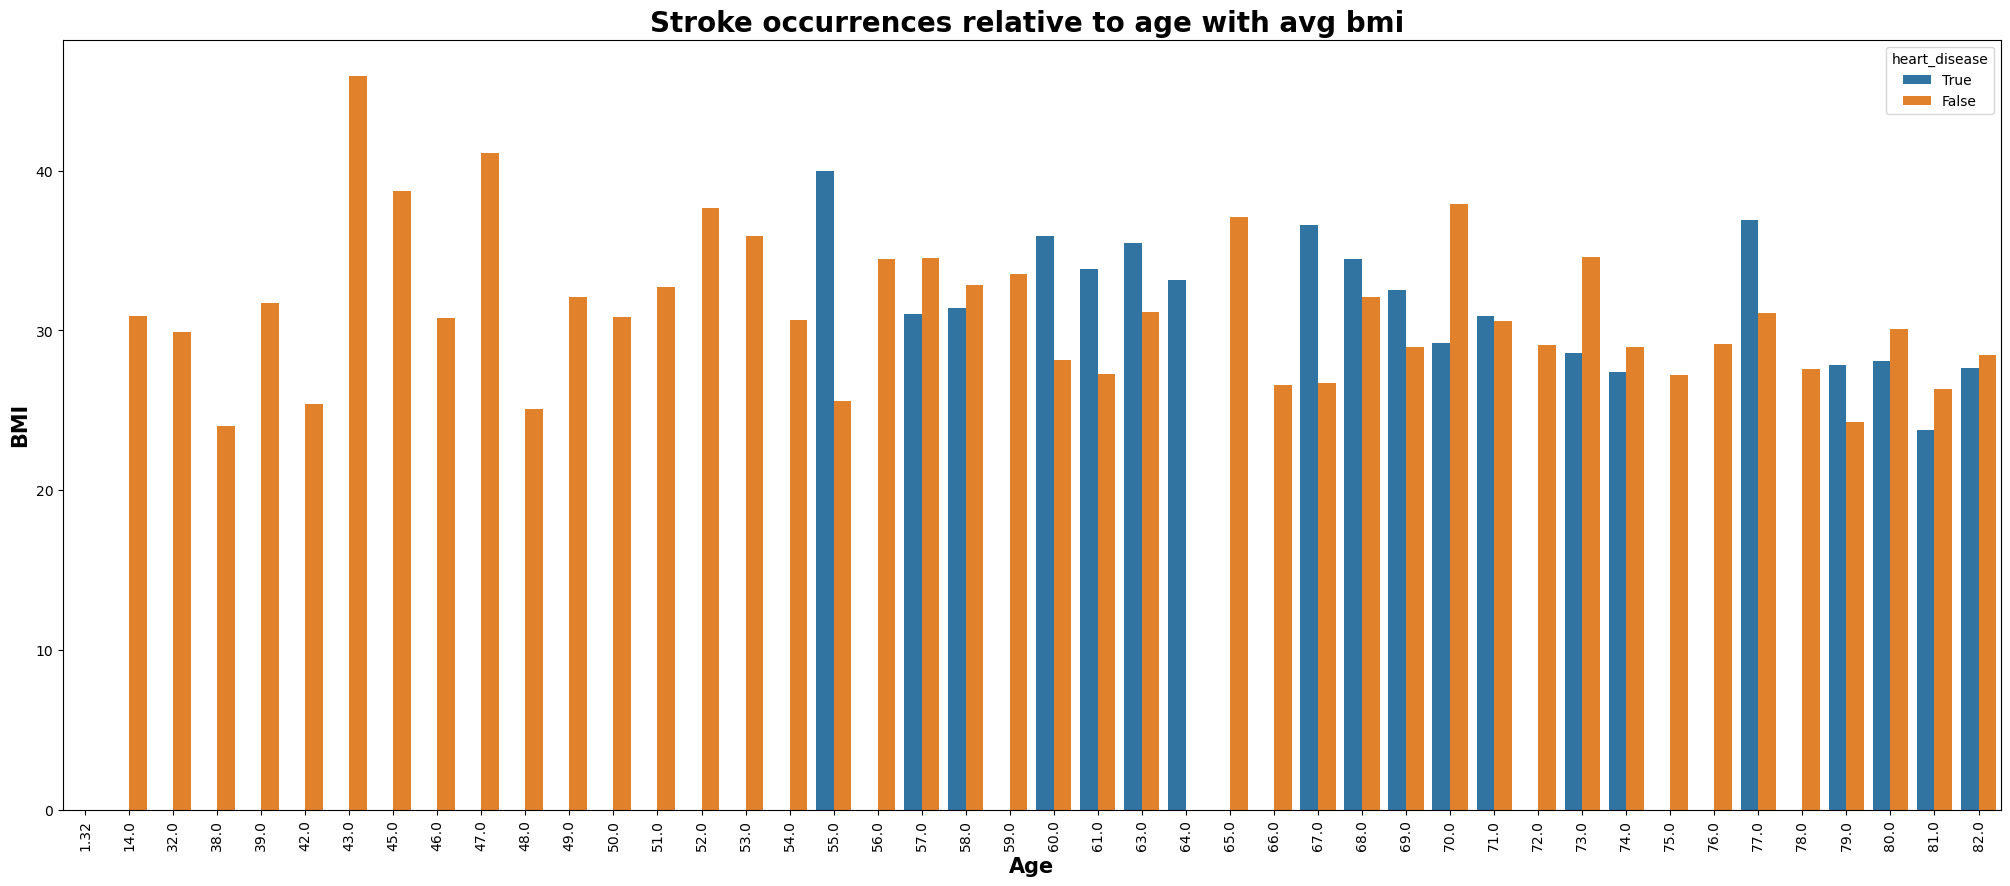

In [25]:
# Set bar plot 
fig, ax = plt.subplots(figsize = (25, 10))
ax = sns.barplot(x= "age", y="bmi", data=stroke_filtered,
                 hue="heart_disease",  errorbar=None)
ax.set_title("Stroke occurrences relative to age with avg bmi ",
             fontsize= 20, fontweight= "bold")
ax.set_ylabel("BMI", fontsize=15, fontweight="bold")
ax.set_xlabel("Age", fontsize=15, fontweight="bold")
plt.xticks(rotation=90);

- Here we can see that the earliest age of stroke in our dataset was `14` and the next occurrence was age 32 but the trend started to become more obvious and `more frequent from the age of 32 and as you get older`

## Explanatory Data Visualization 

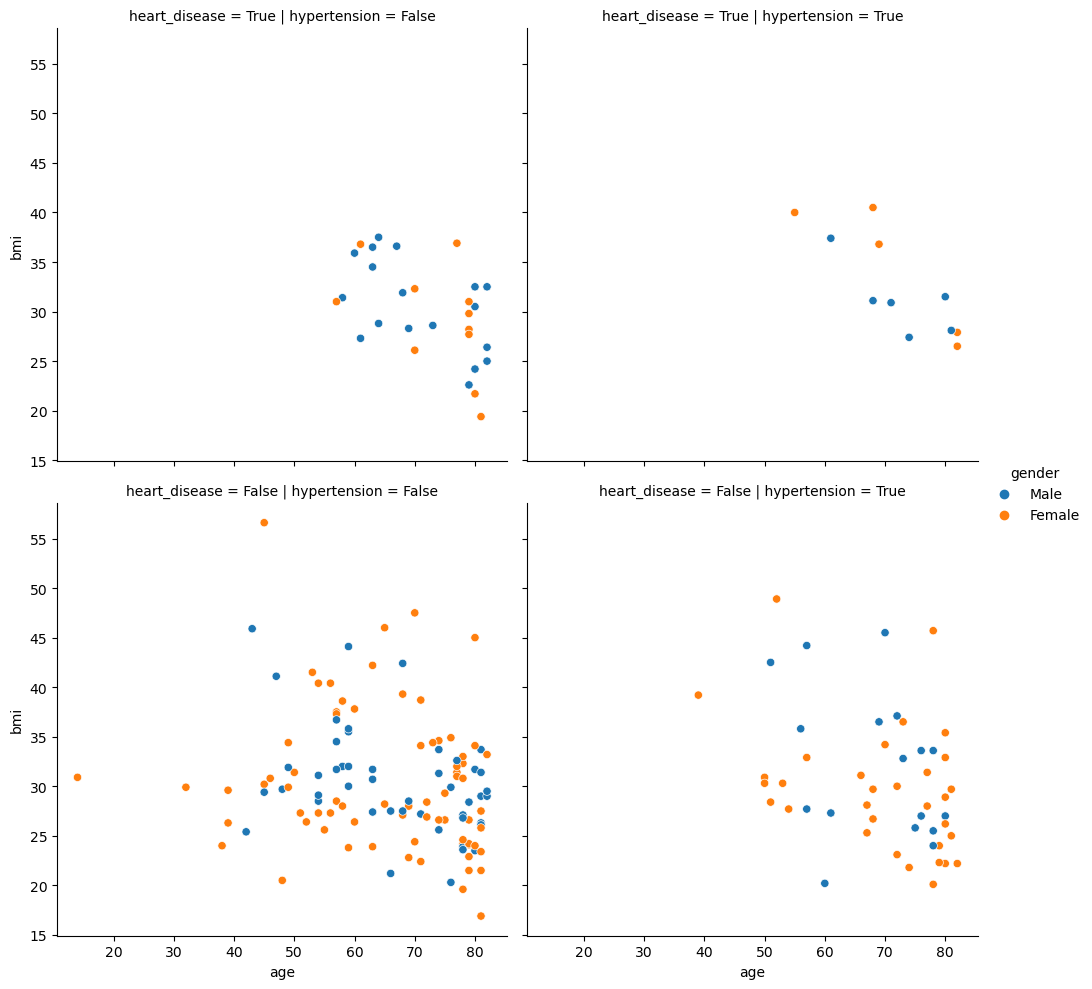

In [26]:
# Display Scatter plot that separtes Male vs Female
ax= sns.relplot(data=stroke_filtered, x="age",y="bmi", 
             hue="gender", col="hypertension", 
            row="heart_disease");

- Here we can see that people amongst all people who had stroke, `majority of them have No previous record of heart disease or hypertension`, However, People with `History of hypertension` are quite relatively high as well  

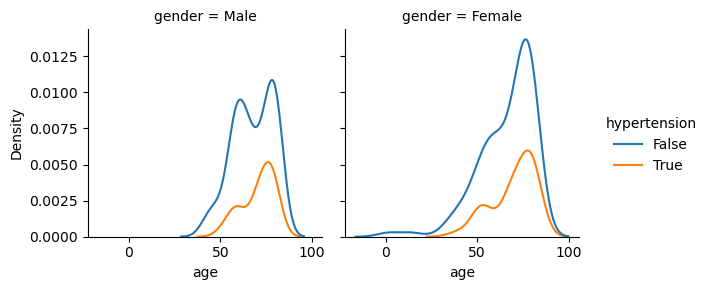

In [27]:
# Display stroke occurrence with Male vs Female relative to age
sns.displot(
    stroke_filtered,
    x="age", hue="hypertension",
    col="gender", col_wrap=2, height=3,
    kind="kde",
);

- Notice that `Female` with age ranging around `50~80 Yrs old` are more prone to not only `stroke` but also with `hypertension` compared to `Male`

## Model Developement

In [28]:
# Display Dataset info again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   Residence_type     5109 non-null   object 
 6   avg_glucose_level  5109 non-null   float64
 7   bmi                4908 non-null   float64
 8   smoking_status     5109 non-null   object 
 9   stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 568.1+ KB


## Addressing Missing Values Using Predictive Model Approach

In [29]:
# Import Model for predicting continous target
from sklearn.ensemble import RandomForestRegressor


### Assign Feature Matrices and Target Vector


In [30]:
# Create new df for train set 
train_df_bmi = df.dropna(axis=0)
train_df_bmi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4908 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   int64  
 3   heart_disease      4908 non-null   int64  
 4   work_type          4908 non-null   object 
 5   Residence_type     4908 non-null   object 
 6   avg_glucose_level  4908 non-null   float64
 7   bmi                4908 non-null   float64
 8   smoking_status     4908 non-null   object 
 9   stroke             4908 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 421.8+ KB


In [31]:
# Create new df for test set
test_df_bmi = df[df["bmi"].isna()]
test_df_bmi.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1546,Male,71.0,1,0,Self-employed,Rural,93.60,NaN,never smoked,0
1214,Male,51.0,0,0,Private,Rural,217.71,NaN,formerly smoked,0
3629,Male,34.0,0,0,Private,Urban,99.23,NaN,smokes,0
4713,Female,70.0,0,1,Self-employed,Rural,65.68,NaN,Unknown,0
78,Female,51.0,0,0,Private,Urban,165.31,NaN,never smoked,1


In [32]:
# Split feature matrices and target vector for train set
X_train_bmi = train_df_bmi.drop(columns="bmi")
y_train_bmi = train_df_bmi["bmi"]

# Split feature matrices and target vector for test set
X_test_bmi = test_df_bmi.drop(columns="bmi")
y_pred_bmi = test_df_bmi["bmi"]

### Predict Missing Values Using RandomForestRegressor

In [33]:
# Instantiate model 
rf_reg = RandomForestRegressor(random_state=42)

# Transformers 
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore")

# Create feature selectors 
col_select = make_column_selector(dtype_include="object")
num_select = make_column_selector(dtype_include="number")
col_tuple = (ohe, col_select)
num_tuple = (scaler, num_select)

# Create Preprocessor
preprocessor = make_column_transformer(num_tuple, col_tuple)

# Create pipeline
rf_reg_pipe = make_pipeline(preprocessor,rf_reg)

# Train the Model
rf_reg_pipe.fit(X_train_bmi, y_train_bmi)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343C1E040>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343C1EA30>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [34]:
# Predict Train set to check model performance
rf_reg_train_pred  = rf_reg_pipe.predict(X_train_bmi)

In [35]:
# Predict Missing values in Bmi
y_pred_bmi = rf_reg_pipe.predict(X_test_bmi)

In [36]:
# Show Model Performance Metrics on Train set
print(f'"train r-squared Score" : {round(r2_score(y_train_bmi,rf_reg_train_pred),3)}')
print(f'"train_MAE Score" : {round(mean_absolute_error(y_train_bmi,rf_reg_train_pred),2)}')
print(f'train_MSE Score" : {round(mean_squared_error(y_train_bmi,rf_reg_train_pred),2)}')
print(f'"train_RMSE Score" : {round(mean_squared_error(y_train_bmi,rf_reg_train_pred,squared=False),2)}')



"train r-squared Score" : 0.884
"train_MAE Score" : 1.97
train_MSE Score" : 7.16
"train_RMSE Score" : 2.68


- Here we can see that our model performed rather Okay-ish, R2 score is not the greatest but MAE shows that we're only missing shy of 2 points on Bmi and a point or 2 delta on bmi is not that significant in terms of real-world data so these results are defenitely better than simple imputer strategy  

In [37]:
# Combine our model prediction to test_df 
test_df_bmi["prediction"] = y_pred_bmi
test_df_bmi

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,prediction
1,Female,61.0,0,0,Self-employed,Rural,202.21,NaN,never smoked,1,36.690
8,Female,59.0,0,0,Private,Rural,76.15,NaN,Unknown,1,29.322
13,Male,78.0,0,1,Private,Urban,219.84,NaN,Unknown,1,29.558
19,Male,57.0,0,1,Govt_job,Urban,217.08,NaN,Unknown,1,31.117
27,Male,58.0,0,0,Private,Rural,189.84,NaN,Unknown,1,33.688
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,Private,Rural,70.15,NaN,formerly smoked,0,31.577
5048,Male,40.0,0,0,Private,Urban,191.15,NaN,smokes,0,30.726
5093,Female,45.0,1,0,Govt_job,Rural,95.02,NaN,smokes,0,36.383
5099,Male,40.0,0,0,Private,Rural,83.94,NaN,smokes,0,28.880


In [38]:
# Drop the missing value feature
test_df_bmi.drop(columns="bmi", inplace=True)

In [39]:
# Replace the column name prediction back to Defaulted
test_df_bmi.rename(columns={"prediction":"bmi"},inplace=True)

In [40]:
# Double check our test_df 
test_df_bmi.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi
1,Female,61.0,0,0,Self-employed,Rural,202.21,never smoked,1,36.690
8,Female,59.0,0,0,Private,Rural,76.15,Unknown,1,29.322
13,Male,78.0,0,1,Private,Urban,219.84,Unknown,1,29.558
19,Male,57.0,0,1,Govt_job,Urban,217.08,Unknown,1,31.117
27,Male,58.0,0,0,Private,Rural,189.84,Unknown,1,33.688


In [41]:
# Combine Train and test DataFrame back together into a new df
cleaned_df = pd.concat([train_df_bmi,test_df_bmi])

In [42]:
# Triple check new df 
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5105
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   work_type          5109 non-null   object 
 5   Residence_type     5109 non-null   object 
 6   avg_glucose_level  5109 non-null   float64
 7   bmi                5109 non-null   float64
 8   smoking_status     5109 non-null   object 
 9   stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 439.1+ KB


- Now that our Dataset is squicky clean, we can now proceed to Predicting our original target `Stroke`

### Custom Class to Instantiate models and metric visuals

In [43]:
class ModelMaker:
    def __init__(self, model, X_train, X_test, y_train, y_test, 
                 labels, with_pca = False, with_smote= False,
                 with_over_sampler = False, with_under_sampler= False):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test 
        self.labels = labels

        # Train model 
        scaler = StandardScaler()
        ohe = OneHotEncoder(handle_unknown='ignore')
        col_select = make_column_selector(dtype_include="object")
        num_select = make_column_selector(dtype_include="number")
        col_tuple = (ohe, col_select)
        num_tuple = (scaler, num_select)
        self.preprocessor = make_column_transformer(num_tuple, col_tuple)
        
        if with_smote and with_pca: 
            smote = SMOTE(k_neighbors=1)
            pca = PCA(n_components=10)
            self.model_pipe = resample_pipeline(self.preprocessor,
                                                smote,pca,model)
      
        elif with_pca: 
            pca = PCA(n_components=10)
            preprocessor_pca = make_pipeline(self.preprocessor,pca)
            self.model_pipe = make_pipeline(preprocessor_pca,model)

        elif with_smote: 
            smote = SMOTE(k_neighbors=1)
            self.model_pipe = resample_pipeline(self.preprocessor,smote,model)
        elif with_over_sampler:
            over_sampler = RandomOverSampler()
            self.model_pipe = resample_pipeline(self.preprocessor,
                                                over_sampler,model)
        
        elif with_under_sampler:
            under_sampler = RandomUnderSampler()
            self.model_pipe = resample_pipeline(self.preprocessor,
                                                under_sampler,model)
        
        else:
            self.model_pipe = make_pipeline(self.preprocessor,model)
        self.model_pipe.fit(X_train,y_train)
        # set hyperparams 
        self.show_params = self.model_pipe.get_params()
        # set prediction
        self.model_train_pred = self.model_pipe.predict(X_train)
        self.model_test_pred = self.model_pipe.predict(X_test)
        # set classfication report
        self.train_dt_report = classification_report(y_train,self.model_train_pred,
                                                target_names=labels)
        self.test_dt_report = classification_report(y_test, self.model_test_pred,
                                            target_names=labels)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, 
                                                              self.model_test_pred).ravel()
        self.sensitivity = self.tp / (self.tp/self.fn)
        self.specificity = self.tn / (self.tn/self.fp)

    # Display Confusion Report 
    def get_report(self):
        report = f"""{self.model} Train Metric Scores: \n {self.train_dt_report} \n
        {self.model} Test Metric Scores: \n {self.test_dt_report}
        Sensitivity = {self.sensitivity}%
        Specificity = {self.specificity}% """
        return print(report)

    def get_visuals(self, normalize = None):


        # Display Confusion Matrix
        fig, axes = plt.subplots(ncols= 2, figsize=(10,5))
        ConfusionMatrixDisplay.from_predictions(self.y_train, 
                                                self.model_train_pred,
                                                ax=axes[0],
                                                cmap="Blues",
                                                normalize=normalize)
        axes[0].set_title("Train CM")
          
        ConfusionMatrixDisplay.from_predictions(self.y_test, 
                                                self.model_test_pred,
                                                ax=axes[1],
                                                cmap="Reds",
                                                normalize=normalize)
        axes[1].set_title("Test CM")
        
        return plt.show()
        
    def run_gs(self,param_matrix:dict) -> dict:
        # Set GS scoring to f1 to fix overfitting 
        self.gs_pipe = GridSearchCV(self.model_pipe,param_matrix,
                                    n_jobs=-1,scoring='f1_micro')
        self.gs_pipe.fit(self.X_train, self.y_train)
        test_accu = round(self.gs_pipe.best_estimator_.score(self.X_test,self.y_test)*100,2)
        train_accu = round(self.gs_pipe.best_estimator_.score(self.X_train,self.y_train)*100,2)
        print(f"Testing Accuracy : {test_accu}")
        print(f"Training Accuracy : {train_accu}")
        print(self.model)
        self.test_proba = self.gs_pipe.predict_proba(self.X_test)[:,1]
        
        return self.gs_pipe.best_params_
    
    def show_roc(self):
        print(f"ROC AUC score : {roc_auc_score(self.y_test,self.test_proba)}")
        return RocCurveDisplay.from_predictions(self.y_test, self.test_proba)

### Assign Feature Matrices and Target Vector

In [44]:
# Train test split
X = cleaned_df.drop(columns="stroke")
y = cleaned_df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)  

In [45]:
# Create Label for all models 
labels = [ "Stroke_free","Stroke"]

### KNearestNeighbor Model

In [46]:
# Instantiate model
knn = ModelMaker(KNeighborsClassifier(),
                 X_train, X_test, y_train, y_test,labels)

In [47]:
# Show Metrics score 
knn.get_report()

KNeighborsClassifier() Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.96      1.00      0.98      3657
      Stroke       0.38      0.03      0.05       174

    accuracy                           0.95      3831
   macro avg       0.67      0.51      0.51      3831
weighted avg       0.93      0.95      0.93      3831
 

        KNeighborsClassifier() Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.94      1.00      0.97      1203
      Stroke       0.20      0.01      0.03        75

    accuracy                           0.94      1278
   macro avg       0.57      0.51      0.50      1278
weighted avg       0.90      0.94      0.91      1278

        Sensitivity = 74.0%
        Specificity = 4.0% 


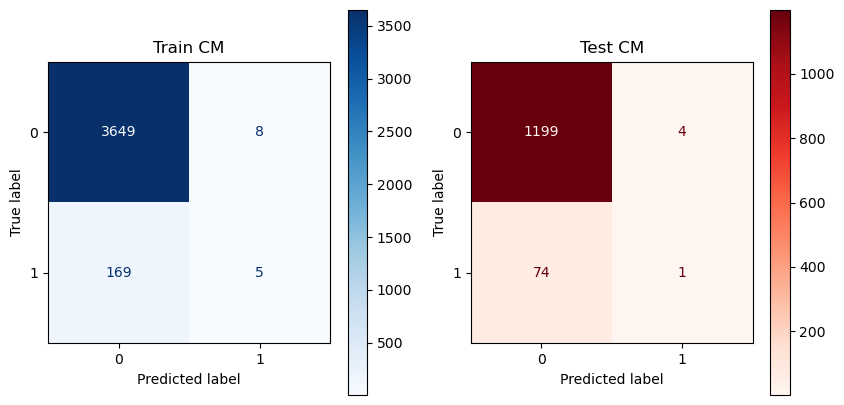

In [48]:
# Show Confustion Matrix
knn.get_visuals()

- Considering the target distribution on our dataset it is expected that our models will struggle to learn the pattern to predict actual stroke patients so we need to pay closer attention with our Sensitivity Score and see what we can do to imporve that later on 

In [49]:
# Check params for Gridsearch 
knn.show_params

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343C1E160>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343C4CA00>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343C1E160>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  <sklearn.compose._column_transformer.make_column

In [50]:
# Set Params for KNN 
Knn_params = {'kneighborsclassifier__n_neighbors':list(range(1,10)),
              'kneighborsclassifier__p':list(range(1,10))}

In [51]:
# Run GridSearch for model tuning
knn.run_gs(Knn_params)

Testing Accuracy : 94.05
Training Accuracy : 95.48
KNeighborsClassifier()


{'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 3}

ROC AUC score : 0.6657633693543917


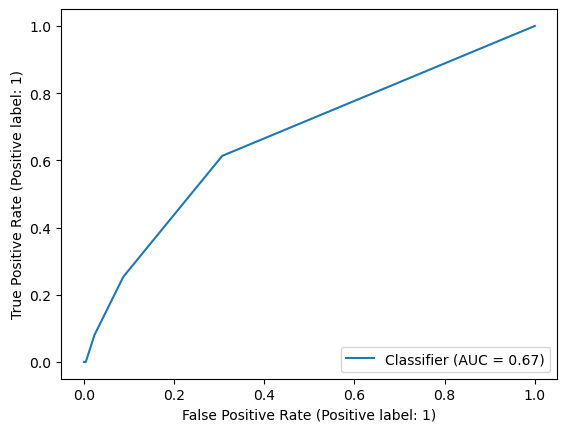

In [52]:
# Show ROC AUC Score
knn.show_roc()

- Horrible Score as expected but we will try to improve this of course! 

In [53]:
# Instantiate KNN tuned model based on GS best params
Knn_tuned = ModelMaker(KNeighborsClassifier(n_neighbors=9, p=3),
                       X_train, X_test, y_train, y_test,labels)

In [54]:
# Show Metric Scores 
Knn_tuned.get_report()

KNeighborsClassifier(n_neighbors=9, p=3) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.96      1.00      0.98      3657
      Stroke       0.60      0.02      0.03       174

    accuracy                           0.95      3831
   macro avg       0.78      0.51      0.51      3831
weighted avg       0.94      0.95      0.93      3831
 

        KNeighborsClassifier(n_neighbors=9, p=3) Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.94      1.00      0.97      1203
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.89      0.94      0.91      1278

        Sensitivity = nan%
        Specificity = 1.0% 


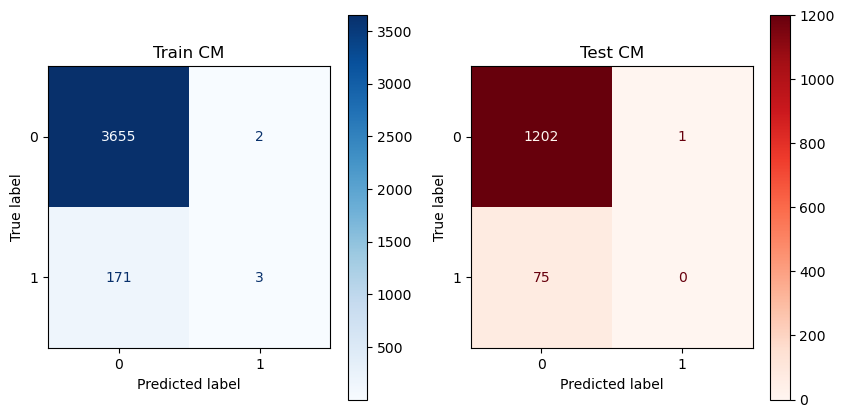

In [55]:
# Show Confusion Matrix
Knn_tuned.get_visuals()

- Not good . . Our "tuned" KNN model became too conservative on predicting postives and went heavy pridicting negatives

## RandomForestClassifier Model

In [56]:
# Instantiate rf model
rf = ModelMaker(RandomForestClassifier(random_state=42),
                X_train, X_test, y_train, y_test, labels)

In [57]:
# Show Metrics score
rf.get_report()

RandomForestClassifier(random_state=42) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       1.00      1.00      1.00      3657
      Stroke       1.00      1.00      1.00       174

    accuracy                           1.00      3831
   macro avg       1.00      1.00      1.00      3831
weighted avg       1.00      1.00      1.00      3831
 

        RandomForestClassifier(random_state=42) Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.94      1.00      0.97      1203
      Stroke       0.50      0.01      0.03        75

    accuracy                           0.94      1278
   macro avg       0.72      0.51      0.50      1278
weighted avg       0.92      0.94      0.91      1278

        Sensitivity = 74.0%
        Specificity = 1.0% 


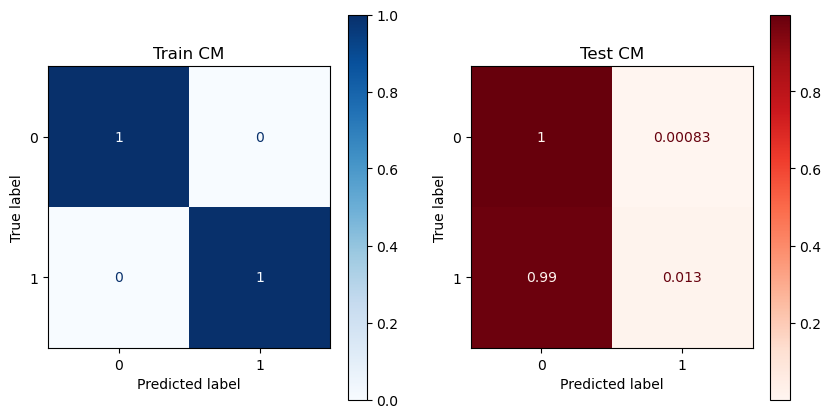

In [58]:
# Show Confustion Matrix 
rf.get_visuals(normalize='true')

- RandomForest did too well on Training set but suffered pretty bad on test set, let's see if we can improve this score after tuning the model

In [59]:
# Get rf params 
rf.show_params

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342379D60>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342812340>)])),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342379D60>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  <sklearn.compose._column_tran

In [60]:
# Params to tune rf 
rf_params = {
    'randomforestclassifier__max_depth': list(range(1,10)),
 'randomforestclassifier__max_leaf_nodes': [1,2,3],
 'randomforestclassifier__max_samples': [20,50,100],
 'randomforestclassifier__min_samples_leaf': [1,2,3],
 'randomforestclassifier__min_samples_split': [2,3,4],
 'randomforestclassifier__n_estimators': [100,200,300]
}

In [61]:
# Run GridSearchCV to tune rf 
rf.run_gs(rf_params) 

Testing Accuracy : 94.13
Training Accuracy : 95.46
RandomForestClassifier(random_state=42)


{'randomforestclassifier__max_depth': 1,
 'randomforestclassifier__max_leaf_nodes': 2,
 'randomforestclassifier__max_samples': 20,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 100}

In [62]:
# Instantiate tuned rf model
rf_tuned = ModelMaker(RandomForestClassifier(max_depth=1,
                                             max_leaf_nodes=2,
                                             max_samples=20,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             n_estimators=100),
                                             X_train, X_test,
                                             y_train, y_test, labels)

In [63]:
# Show Metric scores
rf_tuned.get_report()

RandomForestClassifier(max_depth=1, max_leaf_nodes=2, max_samples=20) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.95      1.00      0.98      3657
      Stroke       0.00      0.00      0.00       174

    accuracy                           0.95      3831
   macro avg       0.48      0.50      0.49      3831
weighted avg       0.91      0.95      0.93      3831
 

        RandomForestClassifier(max_depth=1, max_leaf_nodes=2, max_samples=20) Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.94      1.00      0.97      1203
      Stroke       0.00      0.00      0.00        75

    accuracy                           0.94      1278
   macro avg       0.47      0.50      0.48      1278
weighted avg       0.89      0.94      0.91      1278

        Sensitivity = nan%
        Specificity = 0.0% 


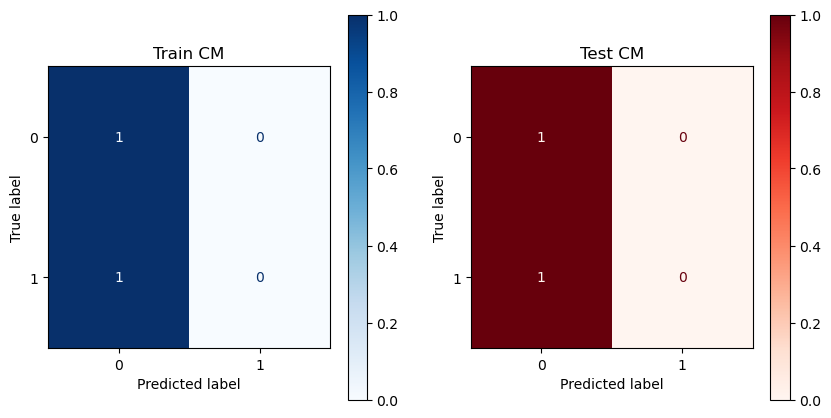

In [64]:
# Show Confusion Matrix
rf_tuned.get_visuals(normalize='true')

- Similar to tuned KNN, tuned rf had worse performance than default params 

# XGBoost Model

In [65]:
# Instantiate Model
xgb = ModelMaker(XGBClassifier(), X_train, X_test, y_train, y_test, labels)

[07:37:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
# Show Metric Scores
xgb.get_report()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.99      1.00      1.00      3657
      Stroke       1.00      0.86      0.92       174

    accuracy                           0.99      3831
   macro avg       1.00      0.93      0.96      3831
weighted avg       0.99      0.99      0.99      3831
 

        X

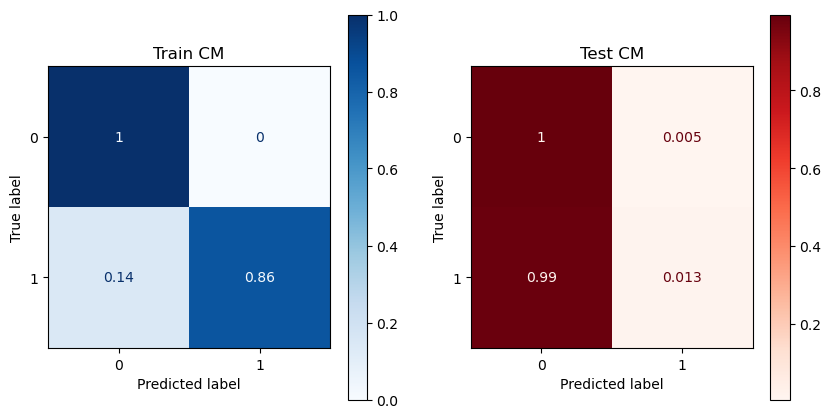

In [67]:
# Show Confusion Matrix 
xgb.get_visuals(normalize='true')

- XGBoost model have similar Sensitivity so let's see if we can improve these scores by tuning the model

In [68]:
# Get params for Xgb
xgb.show_params

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024341DE1430>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342B13B80>)])),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
                 gamma=0, gpu_id=-1, importance_type=None,
                 interaction_constraints='', learning_rate=0.300000012,
                 max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                 monotone_constraints='()', n_estimators=100, n_jobs=32,
                 num_parallel_tree

In [69]:
# Params for Xgb
xgb_params = {
    'xgbclassifier__max_depth': list(range(1,11)),
    'xgbclassifier__n_estimators': [100,150,200,],
    'xgbclassifier__n_jobs': [32,35,37,40]
}

In [70]:
# Run GridSearchCV on xgb
xgb.run_gs(xgb_params)

[07:37:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Testing Accuracy : 94.13
Training Accuracy : 95.46
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


{'xgbclassifier__max_depth': 1,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__n_jobs': 32}

- GS best_params returned same results as default params so no point of rerunning tuned model for xgb

## Model Perfomance Comparison 

KNN scores


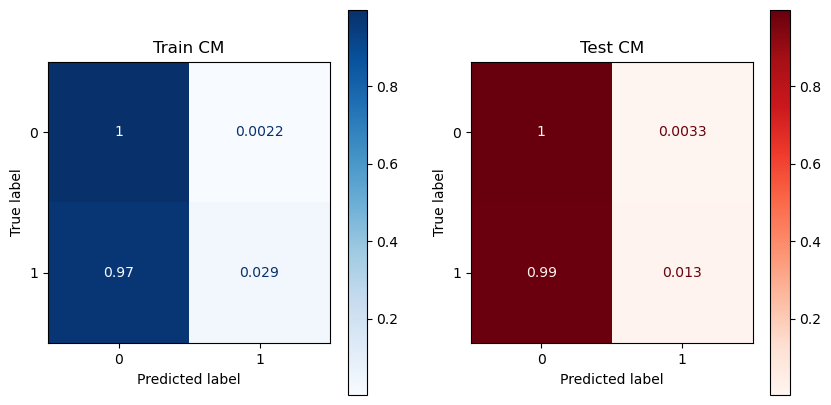

____________________________________________________________________________________________________
RF Scores


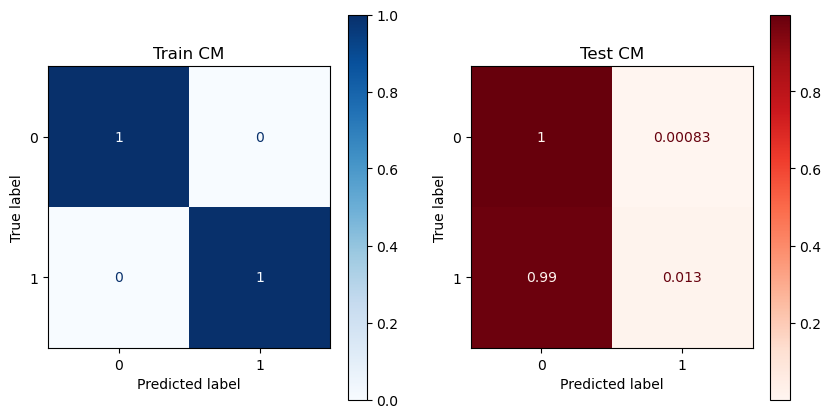

____________________________________________________________________________________________________
XGB Scores


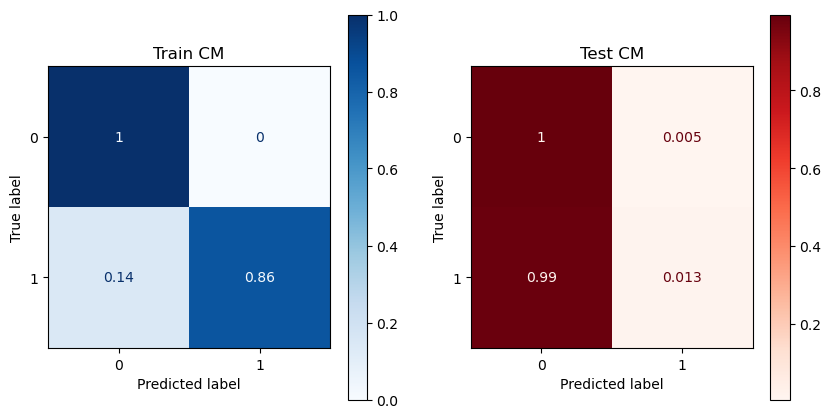

In [71]:
# Display Confusion matrices for all default models 
print("KNN scores")
knn.get_visuals(normalize='true')
print("_"*100)
print("RF Scores")
rf.get_visuals(normalize="true")
print("_"*100)
print("XGB Scores")
xgb.get_visuals(normalize='true')

- Based on these visuals, I think we can do focus on improving RandomForest model perfomance. RF performed well on Training and struggled on test sets. But if we can improve our test set's data we might get better results with this model 

## Feature Engineering and PCA 

In [72]:
# Create new df
df_eng =cleaned_df.copy()

In [73]:
# check df
df_eng.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3199,Female,50.0,0,0,Govt_job,Urban,92.15,20.8,never smoked,0
4500,Male,60.0,0,0,Self-employed,Urban,227.23,40.0,formerly smoked,0
4741,Male,75.0,0,0,Private,Rural,75.47,24.5,formerly smoked,0
984,Male,19.0,0,0,Private,Urban,99.14,28.1,never smoked,0
1081,Female,32.0,0,0,Private,Urban,84.63,40.1,Unknown,0


In [74]:
df_eng["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

- `smoking_status` has some `Unknown` status that we can address using model prediction

In [75]:
# create df for train set
train_df_smoke = df_eng[df_eng['smoking_status']!='Unknown']
train_df_smoke["smoking_status"].value_counts()

never smoked       1892
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [76]:
# Create df for test set 
test_df_smoke = df_eng[df_eng["smoking_status"]== "Unknown"]
test_df_smoke.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
4878,Male,16.0,0,0,children,Rural,82.44,32.6,Unknown,0
4332,Female,2.0,0,0,children,Urban,102.92,17.6,Unknown,0
383,Male,5.0,0,0,children,Rural,85.84,16.4,Unknown,0
738,Female,79.0,0,0,Govt_job,Urban,74.22,29.7,Unknown,0
2429,Male,14.0,0,0,Self-employed,Urban,187.22,29.7,Unknown,0


In [77]:
# Split feature matrices and target vector for train set
X_train_smoke = train_df_smoke.drop(columns="smoking_status")
y_train_smoke = train_df_smoke["smoking_status"]

# Split feature matrices and target vector for test set
X_test_smoke = test_df_smoke.drop(columns="smoking_status")
y_pred_smoke = test_df_bmi["smoking_status"]

In [78]:
# Instantiate model 
rf_smoke = RandomForestClassifier(random_state=42)

# Transformers 
scaler_2 = StandardScaler()
ohe_2 = OneHotEncoder(handle_unknown="ignore")

# Create feature selectors 
col_select = make_column_selector(dtype_include="object")
num_select = make_column_selector(dtype_include="number")
col_tuple = (ohe_2, col_select)
num_tuple = (scaler_2, num_select)

# Create Preprocessor
preprocessor_smoke = make_column_transformer(num_tuple, col_tuple)

# Create pipeline
rf_smoke_pipe = make_pipeline(preprocessor_smoke,rf_smoke)

# Train the Model
rf_smoke_pipe.fit(X_train_smoke, y_train_smoke)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342AFEEB0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000024342AFE4C0>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [79]:
# Predict train set
rf_smoke_train_preds = rf_smoke_pipe.predict(X_train_smoke)

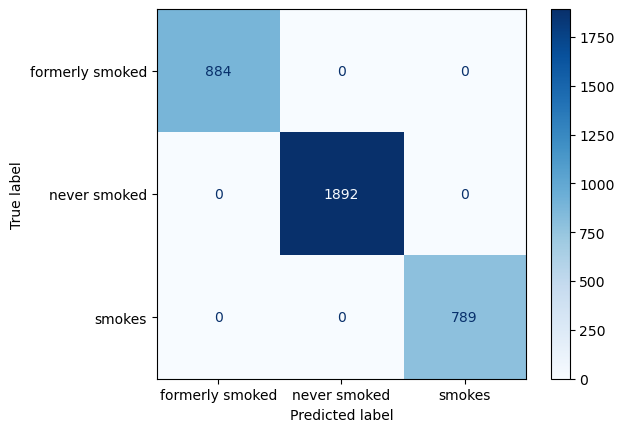

In [80]:
# Check model performance using Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train_smoke, 
                                        rf_smoke_train_preds,
                                        cmap="Blues",
                                        normalize=None);

- Looking Promising! either our model is doing really well or our training set is overfitted, but defenitely better than "Unknown"

In [81]:
# Predict the Unknown values 
y_pred_smoke = rf_smoke_pipe.predict(X_test_smoke)
y_pred_smoke 

array(['never smoked', 'formerly smoked', 'smokes', ..., 'never smoked',
       'formerly smoked', 'never smoked'], dtype=object)

In [82]:
# Combine our model prediction to test_df 
test_df_smoke["prediction"] = y_pred_smoke
test_df_smoke.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,prediction
3361,Male,48.0,0,0,Private,Rural,62.89,29.6,Unknown,0,never smoked
2152,Male,10.0,0,0,children,Urban,55.34,15.3,Unknown,0,never smoked
1498,Male,38.0,0,0,Private,Rural,86.86,36.5,Unknown,0,never smoked
1013,Female,77.0,1,0,Self-employed,Urban,102.01,29.5,Unknown,0,never smoked
1693,Female,20.0,0,0,Private,Urban,95.50,31.3,Unknown,0,never smoked


In [83]:
# Drop the missing value feature
test_df_smoke.drop(columns="smoking_status", inplace=True)

In [84]:
# Double check
test_df_smoke.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,stroke,prediction
3491,Female,24.0,0,0,Private,Rural,97.95,34.7,0,never smoked
3144,Female,79.0,0,0,Self-employed,Rural,82.07,30.4,0,never smoked
1248,Female,30.0,0,0,Private,Urban,96.42,22.6,0,never smoked
2687,Female,2.0,0,0,children,Rural,100.66,18.5,0,never smoked
4256,Female,5.0,0,0,children,Rural,64.45,21.7,0,formerly smoked


In [85]:
# Replace the column name prediction back to Defaulted
test_df_smoke.rename(columns={"prediction":"smoking_status"},inplace=True)

In [86]:
# Double check
test_df_smoke.sample(5)

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,stroke,smoking_status
2655,Female,44.0,0,0,Govt_job,Urban,97.16,33.1,0,never smoked
4395,Female,79.0,0,0,Self-employed,Rural,65.58,26.1,0,never smoked
760,Female,39.0,0,0,Private,Urban,77.54,32.7,0,never smoked
4594,Male,16.0,0,0,Private,Urban,84.10,19.3,0,never smoked
3036,Male,40.0,0,0,Private,Urban,104.64,24.9,0,never smoked


In [87]:
# Combine Train and test DataFrame back together into a new df
df_eng_final = pd.concat([train_df_smoke,test_df_smoke])

In [88]:
# Triple check
df_eng_final["smoking_status"].value_counts()

never smoked       3090
formerly smoked    1129
smokes              890
Name: smoking_status, dtype: int64

In [89]:
# Train Test Split 
X_final = df_eng_final.drop(columns='stroke')
y_final = df_eng_final['stroke']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_final,
                                                            y_final,
                                                            random_state=42) 

In [90]:
# Instantiate rf model with default params , PCA and SMOTE
rf_eng_pca_smote = ModelMaker(RandomForestClassifier(random_state=42),
                                                     X_train_f,
                                                     X_test_f,
                                                     y_train_f,
                                                     y_test_f,
                                                     labels,
                                                     with_pca=True,
                                                     with_smote=True)

In [91]:
# Show Metric Scores
rf_eng_pca_smote.get_report()

RandomForestClassifier(random_state=42) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       1.00      1.00      1.00      3651
      Stroke       1.00      1.00      1.00       180

    accuracy                           1.00      3831
   macro avg       1.00      1.00      1.00      3831
weighted avg       1.00      1.00      1.00      3831
 

        RandomForestClassifier(random_state=42) Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.95      0.97      0.96      1209
      Stroke       0.26      0.16      0.20        69

    accuracy                           0.93      1278
   macro avg       0.60      0.57      0.58      1278
weighted avg       0.92      0.93      0.92      1278

        Sensitivity = 58.0%
        Specificity = 32.0% 


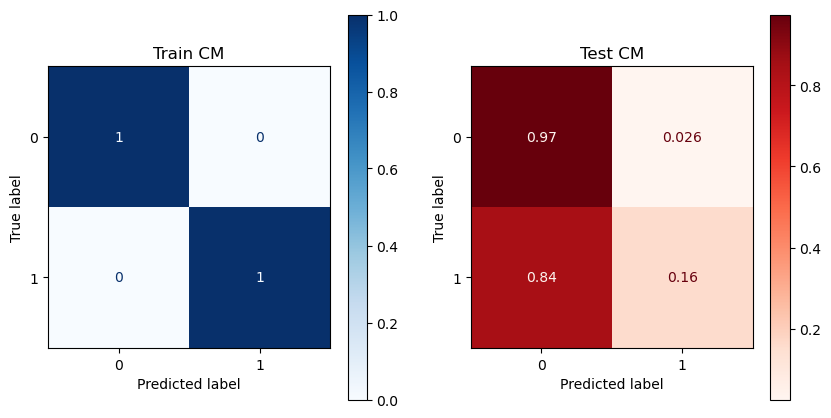

In [92]:
# Show Confusion Matrix
rf_eng_pca_smote.get_visuals(normalize='true')

- Interesting, we did get more data in test set but doesn't seem to be helping our model find the pattern either
- Our model is overfitted , let's try to tune this model and see if we can improve these scores

In [93]:
rf_eng_pca_smote.show_params

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000243441F1340>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x0000024343B95C40>)])),
  ('smote', SMOTE(k_neighbors=1)),
  ('pca', PCA(n_components=10)),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000243441F1340>),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignor

In [94]:
# Set params 
rf_eng_pca_smote_params = {
    'smote__k_neighbors': list(range(1,10)),
    'pca__n_components': list(range(9,15)),
    'randomforestclassifier__max_depth': list(range(5,11)),
    'randomforestclassifier__n_estimators':list(range(40,101,20))
}

In [95]:
# Run Gridsearch with scoring set to 'f1_micro'
rf_eng_pca_smote.run_gs(rf_eng_pca_smote_params)

Testing Accuracy : 85.76
Training Accuracy : 92.35
RandomForestClassifier(random_state=42)


{'pca__n_components': 11,
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__n_estimators': 100,
 'smote__k_neighbors': 1}

In [96]:
# Instantiate final tuned rf model
rf_final = ModelMaker(RandomForestClassifier(max_depth=10,
                                             n_estimators=39,
                                             random_state=42),
                                             X_train_f,
                                            X_test_f,
                                            y_train_f,
                                            y_test_f,
                                            labels,
                                            with_pca=True,
                                            with_smote=True)

In [97]:
# Show metric score
rf_final.get_report()

RandomForestClassifier(max_depth=10, n_estimators=39, random_state=42) Train Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       1.00      0.90      0.95      3651
      Stroke       0.33      0.99      0.50       180

    accuracy                           0.91      3831
   macro avg       0.66      0.95      0.72      3831
weighted avg       0.97      0.91      0.93      3831
 

        RandomForestClassifier(max_depth=10, n_estimators=39, random_state=42) Test Metric Scores: 
               precision    recall  f1-score   support

 Stroke_free       0.96      0.86      0.91      1209
      Stroke       0.15      0.41      0.21        69

    accuracy                           0.84      1278
   macro avg       0.55      0.64      0.56      1278
weighted avg       0.92      0.84      0.87      1278

        Sensitivity = 41.0%
        Specificity = 164.0% 


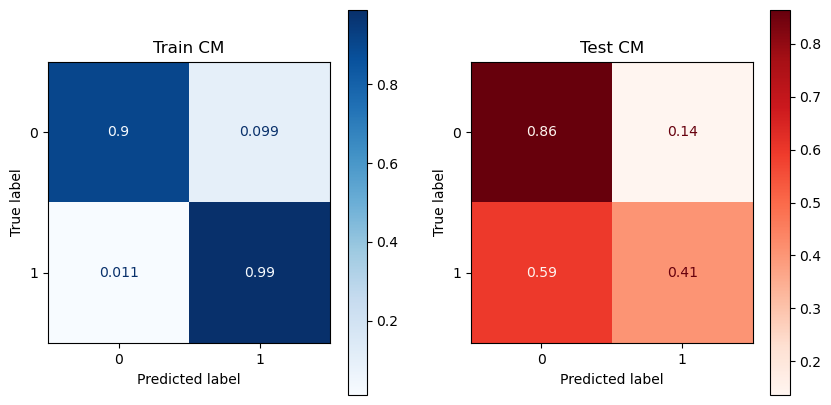

In [98]:
# Show Confusion Matrix
rf_final.get_visuals(normalize='true')

- Here we can see that adding resampling technique Smote with k_neighbor set to 1 and PCA we're able get (not the best) but better prediction in test sets 
- we should try different model architecture and see if it will perform better given the Dataset imbalance 

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1209
           1       0.14      0.75      0.24        69

    accuracy                           0.74      1278
   macro avg       0.56      0.75      0.54      1278
weighted avg       0.94      0.74      0.81      1278



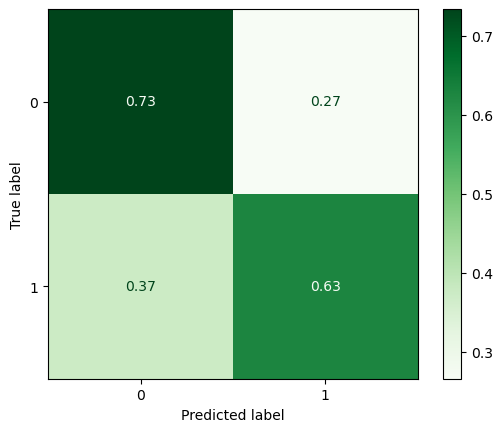

In [102]:
#Create model pipeline, SMOTE, and model
from sklearn.linear_model import LogisticRegression

smote = SMOTE()
pca = PCA()
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote_pipe = resample_pipeline(preprocessor,
                                       smote,pca,
                                       log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train_f, y_train_f)
test_preds = log_reg_smote_pipe.predict(X_test_f)
print(classification_report(y_test_f, test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, test_preds,normalize='true',cmap='Greens');

Looks like we have a winner, Linear Base model seemed to perform best on our dataset accurately predicting 63% of actual stroke occurrences 